# Accessing satellite data from AWS

This example notebook shows how to obtain Sentinel-2 imagery and additional data from [AWS S3 storage buckets](https://aws.amazon.com/s3/). The data at AWS is the same as original S-2 data provided by ESA.

The ```sentinelhub``` package supports obtaining data by specifying products or by specifying tiles. It can download data either to the same file structure as it is at AWS or it can download data into original ```.SAFE``` file structure [introduced by ESA](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats).

Before testing any of the examples below please check [Configuration paragraph](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#amazon-s3-capabilities) for details about configuring AWS credentials and information about charges.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Note: `matplotlib` is not a dependency of `sentinelhub` and is used in these examples for visualizations.

## Searching for available data

For this functionality Sentinel Hub instance ID has to be configured according to [Configuration paragraph](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#sentinel-hub-capabilities).

In [3]:
from sentinelhub import WebFeatureService, BBox, CRS, DataCollection, SHConfig

config = SHConfig()

if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")


The archive of Sentinel-2 data at AWS consists of two buckets, one containing L1C and the other containing L2A data. There are multiple ways to search the archive for specific tiles and products:

- Manual search using [aws_cli](https://docs.aws.amazon.com/cli/latest/reference/s3/ls.html), e.g.:

```bash
aws s3 ls s3://sentinel-s2-l2a/tiles/33/U/WR/ --request-payer
```

- Manual search using service available at https://roda.sentinel-hub.com/<bucket name>/, which does not require authentication, e.g.:
    
    https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/1/C/CV/2017/1/14/0/

- Automatic search by a tile id or by location and time interval using Sentinel Hub Catalog API. More examples are available in [this notebook](./data_search.ipynb).    
    
- Automatic search by location and time interval using Sentinel Hub Web Feature Service (WFS):

In [4]:
search_bbox = BBox(bbox=[46.16, -16.15, 46.51, -15.58], crs=CRS.WGS84)
search_time_interval = ('2017-12-01T00:00:00', '2017-12-15T23:59:59')


wfs_iterator = WebFeatureService(
    search_bbox,
    search_time_interval,
    data_collection=DataCollection.SENTINEL2_L1C,
    maxcc=1.0,
    config=config
)

for tile_info in wfs_iterator:
    print(tile_info)

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[45.93178396701427, -15.374656928849852], [46.95453856838988, -15.368029754563597], [46.96412360581364, -16.360077552492225], [45.93635618696065, -16.3671551019236], [45.93178396701427, -15.374656928849852]]]]}, 'properties': {'id': 'S2B_OPER_MSI_L1C_TL_MTI__20171215T085654_A004050_T38LPH_N02.06', 'date': '2017-12-15', 'time': '07:12:03', 'path': 's3://sentinel-s2-l1c/tiles/38/L/PH/2017/12/15/0', 'crs': 'EPSG:32738', 'mbr': '600000,8190220 709800,8300020', 'cloudCoverPercentage': 28.27}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[45.93178396701427, -15.374656928849852], [46.95453856838988, -15.368029754563597], [46.96412360581364, -16.360077552492225], [45.93635618696065, -16.3671551019236], [45.93178396701427, -15.374656928

From obtained WFS iterator we can extract info which uniquely defines each tile.

In [5]:
wfs_iterator.get_tiles()

[('38LPH', '2017-12-15', 0),
 ('38LPH', '2017-12-10', 0),
 ('38LPH', '2017-12-5', 0)]

- Automatic search with functions from [sentinelhub.opensearch](https://sentinelhub-py.readthedocs.io/en/latest/opensearch.html) module (no authentication required):

In [6]:
from sentinelhub import get_area_info

for tile_info in get_area_info(search_bbox, search_time_interval, maxcc=0.5):
    print(tile_info)

{'type': 'Feature', 'id': '985b7c0c-5d4a-5105-a37b-ef41f4092392', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[45.931783967, -15.374656929], [46.954538568, -15.368029755], [46.964123606, -16.360077552], [45.936356187, -16.367155102], [45.931783967, -15.374656929]]]]}, 'properties': {'collection': 'Sentinel2', 'license': {'licenseId': 'unlicensed', 'hasToBeSigned': 'never', 'grantedCountries': None, 'grantedOrganizationCountries': None, 'grantedFlags': None, 'viewService': 'public', 'signatureQuota': -1, 'description': {'shortName': 'No license'}}, 'productIdentifier': 'S2B_OPER_MSI_L1C_TL_MTI__20171215T085654_A004050_T38LPH_N02.06', 'parentIdentifier': None, 'title': 'S2B_OPER_MSI_L1C_TL_MTI__20171215T085654_A004050_T38LPH_N02.06', 'description': None, 'organisationName': None, 'startDate': '2017-12-15T07:12:03Z', 'completionDate': '2017-12-15T07:12:03Z', 'productType': 'S2MSI1C', 'processingLevel': '1C', 'platform': 'Sentinel-2', 'instrument': 'MSI', 'resolution': 10, 'sens

## Download data

Once we have found correct tiles or products we can download them and explore the data. Note that in order to do that, you have to provide AWS credentials to the config. Please see also [documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#amazon-s3-capabilities).

### Aws Tile

Sentinel-2 tile can be uniquely defined either with ESA tile ID (e.g. `L1C_T01WCV_A012011_20171010T003615`) or with tile name (e.g. `T38TML` or `38TML`), sensing time and AWS index. The AWS index is the last number in tile AWS path (e.g. https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/1/C/CV/2017/1/14/0/ → `0`).

The package works with the second tile definition. To transform tile ID to `(tile_name, time, aws_index)` do the following:

In [7]:
from sentinelhub import AwsTile

tile_id = 'S2A_OPER_MSI_L1C_TL_MTI__20151219T100121_A002563_T38TML_N02.01'
tile_name, time, aws_index = AwsTile.tile_id_to_tile(tile_id)
tile_name, time, aws_index

('38TML', '2015-12-19', 1)

Now we are ready to download the data. Let's download only bands `B8A` and `B10`, meta data files `tileInfo.json`, `preview.jp2` and pre-calculated cloud mask `qi/MSK_CLOUDS_B00`. We will save everything into folder `./AwsData`.

In [9]:
from sentinelhub import AwsTileRequest

bands = ['B8A', 'B10']
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './AwsData'

request = AwsTileRequest(
    tile=tile_name,
    time=time,
    aws_index=aws_index,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
)

request.save_data()  # This is where the download is triggered

Note that upon calling this method again the data won't be re-downloaded unless we set the parameter `redownload=True`.

To obtain downloaded data we can simply do:

In [10]:
data_list = request.get_data()  # This will not redownload anything because data is already stored on disk

b8a, b10, tile_info, preview, cloud_mask = data_list

Download and reading could also be done in a single call `request.get_data(save_data=True)`.

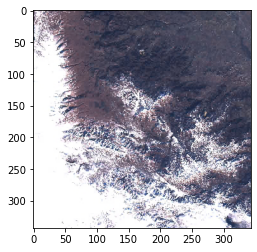

In [11]:
plt.imshow(preview);

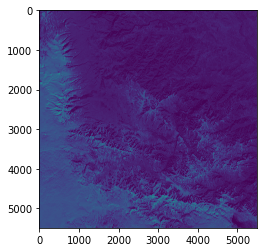

In [12]:
plt.imshow(b8a);

### Aws Product

Sentinel-2 product is uniquely defined by ESA product ID. We can obtain data for the whole product

In [13]:
from sentinelhub import AwsProductRequest

product_id = 'S2A_MSIL1C_20171010T003621_N0205_R002_T01WCV_20171010T003615'

request = AwsProductRequest(product_id=product_id, data_folder=data_folder)

# Uncomment the the following line to download the data:
# data_list = request.get_data(save_data=True)

If `bands` parameter is not defined all bands will be downloaded. If `metafiles` parameter is not defined no additional metadata files will be downloaded.


### Data into .SAFE structure

The data can also be downloaded into .SAFE structure by specifying `safe_format=True`. The following code will download data from upper example again because now data will be stored in different folder structure.

In [14]:
tile_request = AwsTileRequest(
    tile=tile_name,
    time=time,
    aws_index=aws_index,
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    safe_format=True
)

# Uncomment the the following line to download the data:
# tile_request.save_data()

In [15]:
product_id = 'S2A_OPER_PRD_MSIL1C_PDMC_20160121T043931_R069_V20160103T171947_20160103T171947'

product_request = AwsProductRequest(
    product_id=product_id,
    bands=['B01'],
    data_folder=data_folder,
    safe_format=True
)

# Uncomment the the following line to download the data:
# product_request.save_data()

Older products contain multiple tiles. In case would like to download only some tiles it is also possible to specify a list of tiles to download.

In [16]:
product_request = AwsProductRequest(
    product_id=product_id,
    tile_list=['T14PNA', 'T13PHT'],
    data_folder=data_folder,
    safe_format=True
)

# Uncomment the the following line to download the data:
# product_request.save_data()